Carichiamo il dataset

In [1]:
import pandas as pd
import re
df=pd.read_csv('bln_reuters_climate_finance_2015to2020.csv')

/tmp/ipykernel_341573/2462222184.py:3: DtypeWarning: Columns (28,29,30,32,34,35,36,38,39,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('bln_reuters_climate_finance_2015to2020.csv')


In [2]:
italia = df[df['reporting_party']=='italy']

In [41]:
italia

,id,year,reporting_party,recipient_country_region_project_programme,recipient,recipient_continent_or_region,assigned_geography,usd,euro,corrected_usd,...,australian_dollar,romanian_leu,swedish_krona,canadian_dollar,new_zealand_dollar,czech_koruna,bulgarian_lev,icelandic_krona,polish_zloty,hungarian_forint
1255,1255,2018,italy,Africa / Biosafety,NaN,africa,africa,12007037.78,10169961.00,12007037.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,1256,2018,italy,Afghanistan / Afghanistan Reconstruction Trust...,afghanistan,NaN,asia,4722550.18,4000000.00,4722550.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,1257,2018,italy,Syrian Arab Republic / Protracted crises: huma...,syrian arab republic,NaN,asia,4722550.18,4000000.00,4722550.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,1258,2018,italy,Other (South of Sahara) / Emergency initiative...,"chad, cameroon",NaN,africa,4250295.16,3600000.00,4250295.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1259,1259,2018,italy,Somalia / Integrated humanitarian assistance t...,somalia,NaN,africa,3541912.63,3000000.00,3541912.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43355,43378,2015,italy,Jordan / Jordan / Asia (Middle East Asia) / Pr...,jordan,NaN,asia,170.44,153.65,170.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43356,43379,2015,italy,Benin / Benin / Africa (South of Sahara) / Pro...,benin,NaN,africa,66.91,60.32,66.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43357,43380,2015,italy,Mali / Mali / Africa (South of Sahara) / Water...,mali,NaN,africa,17.98,16.21,17.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43358,43381,2015,italy,Other (Developing countries) / Ocean Sanctuary...,NaN,developing countries,continent_unspecified,284993.42,256921.57,284993.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from tqdm import tqdm

descriptions=italia["additional_information"].dropna().unique()


# list of models to apply
model_list=["ESGBERT/EnvRoBERTa-environmental", "climatebert/environmental-claims","climatebert/renewable"]

results={}


for model_name in model_list:
    # load model and tokenizer in cpu
    print(f"Loading model {model_name}")
    model=AutoModelForSequenceClassification.from_pretrained(model_name)
    if "climate" in model_name:
        tokenizer=AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-detector", max_len=512)
    else:  
        tokenizer=AutoTokenizer.from_pretrained(model_name, max_len=512)
    # load pipeline
    classifier=pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device="cpu")
    print("Running classifier")
    pipe_results=list()
    for out in tqdm(classifier(descriptions.tolist(), padding=True, truncation=True)):
        pipe_results.append(out)
    results[model_name]=pipe_results
    print(f"Done with model {model_name}")
    
    

Loading model ESGBERT/EnvRoBERTa-environmental
Running classifier


100%|██████████| 2251/2251 [00:00<00:00, 2525783.39it/s]


Done with model ESGBERT/EnvRoBERTa-environmental
Loading model climatebert/environmental-claims
Running classifier


100%|██████████| 2251/2251 [00:00<00:00, 2737424.85it/s]


Done with model climatebert/environmental-claims
Loading model climatebert/renewable
Running classifier


100%|██████████| 2251/2251 [00:00<00:00, 2799104.15it/s]

Done with model climatebert/renewable


In [58]:
# transform results into a dataframe
df_results=pd.DataFrame(results)

In [60]:
# for each col of the df, unpack the dict and create a new column
for col in df_results.columns:
    df_results[col+"_label"]=df_results[col].apply(lambda x: x["label"])
    df_results[col+"_score"]=df_results[col].apply(lambda x: x["score"])
    

In [67]:
# keep only the label columns

df_results=df_results[[col for col in df_results.columns if "label" in col]]

df_results

,ESGBERT/EnvRoBERTa-environmental_label,climatebert/environmental-claims_label,climatebert/renewable_label
0,none,no,LABEL_1
1,none,no,LABEL_0
2,environmental,no,LABEL_0
3,none,no,LABEL_0
4,none,no,LABEL_0
...,...,...,...
2246,none,yes,LABEL_0
2247,none,no,LABEL_0
2248,none,no,LABEL_0
2249,none,yes,LABEL_0


In [68]:
# transform the labels into binary
df_results["ESGBERT/EnvRoBERTa-environmental_label"]=df_results["ESGBERT/EnvRoBERTa-environmental_label"].replace({"none":0, "environmental":1})
df_results["climatebert/environmental-claims_label"]=df_results["climatebert/environmental-claims_label"].replace({"no":0, "yes":1})
df_results["climatebert/renewable_label"]=df_results["climatebert/renewable_label"].replace({"LABEL_0":0, "LABEL_1":1})



In [70]:
# see cross tabulation  
pd.crosstab(df_results["ESGBERT/EnvRoBERTa-environmental_label"], df_results["climatebert/environmental-claims_label"])


climatebert/environmental-claims_label,0,1
ESGBERT/EnvRoBERTa-environmental_label,,
0,1349,68
1,603,231


In [71]:
pd.crosstab(df_results["ESGBERT/EnvRoBERTa-environmental_label"], df_results["climatebert/renewable_label"])

climatebert/renewable_label,0,1
ESGBERT/EnvRoBERTa-environmental_label,,
0,1361,56
1,739,95


In [73]:
pd.crosstab(df_results["climatebert/environmental-claims_label"], df_results["climatebert/renewable_label"])

climatebert/renewable_label,0,1
climatebert/environmental-claims_label,,
0,1821,131
1,279,20


In [74]:
# see how many are classified as environmental by all models

df_results["all"]=df_results["ESGBERT/EnvRoBERTa-environmental_label"]+df_results["climatebert/environmental-claims_label"]+df_results["climatebert/renewable_label"]

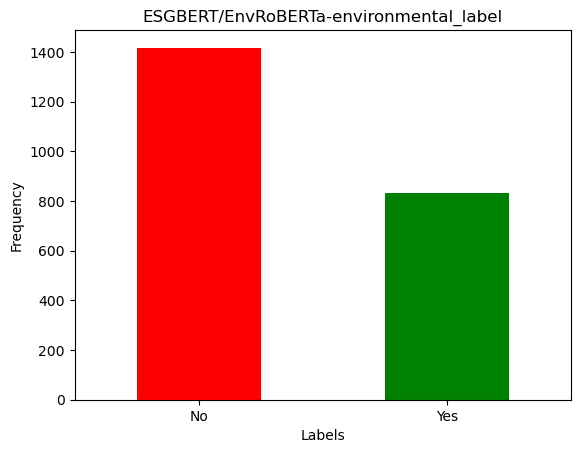

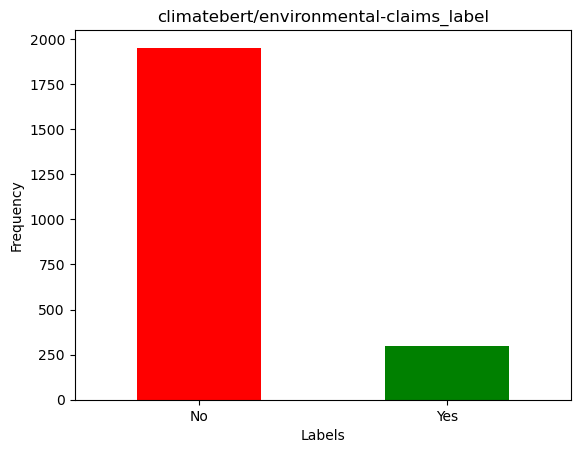

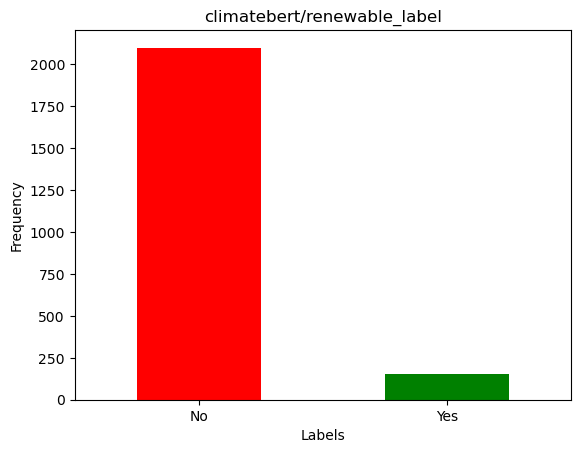

In [98]:
# plot the results
import matplotlib.pyplot as plt

# for each model, plot the distribution of the labels
for col in df_results.columns:
    if "label" in col:
        plt.figure()
        plt.title(col)
        ax = df_results[col].value_counts().plot(kind="bar", color=["red", "green"])
        ax.set_xlabel("Labels")  # Add x-axis label under the bars
        ax.set_ylabel("Frequency")  # Add y-axis label under the bars
        ax.set_xticklabels(["No", "Yes"], rotation=0, ha='center')  # Set x-axis labels as "No" and "Yes"
        plt.show()
